# Setup S3 Buckets

In [1]:
# List the S3 public bucket content
!aws s3 ls s3://ads508-group7/

                           PRE Unsaved/
2025-03-15 21:02:43     546709 2023_Registered_Foreclosure_Properties.csv
2025-03-15 21:02:44     552165 2024_Registered_Foreclosure_Properties.csv
2025-03-15 21:40:42   92038326 Arrest_Data_from_2020_to_Present.csv
2025-03-15 21:40:42  255509498 Crime_Data_from_2020_to_Present.csv


In [2]:
import boto3
import sagemaker
import pandas as pd
from pyathena import connect

# create sagemaker session
sess =  sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
# Set S3 Source Location (Public S3 Bucket)
s3_public_path = "s3://ads508-group7"

In [4]:
%store s3_public_path

Stored 's3_public_path' (str)


In [5]:
# Set S3 Destination Location (Private S3 Bucket)
s3_private_path = "s3://{}/ads508-group7".format(bucket)
print(s3_private_path)

s3://sagemaker-us-east-1-026652244786/ads508-group7


In [6]:
%store s3_private_path

Stored 's3_private_path' (str)


In [7]:
#Copy Data From the Public S3 Bucket to our Private S3 Bucket in this Account

In [8]:
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "2023_Registered_Foreclosure_Properties.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "2024_Registered_Foreclosure_Properties.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "Arrest_Data_from_2020_to_Present.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "Crime_Data_from_2020_to_Present.csv"

copy: s3://ads508-group7/2023_Registered_Foreclosure_Properties.csv to s3://sagemaker-us-east-1-026652244786/ads508-group7/2023_Registered_Foreclosure_Properties.csv
copy: s3://ads508-group7/2024_Registered_Foreclosure_Properties.csv to s3://sagemaker-us-east-1-026652244786/ads508-group7/2024_Registered_Foreclosure_Properties.csv
copy: s3://ads508-group7/Arrest_Data_from_2020_to_Present.csv to s3://sagemaker-us-east-1-026652244786/ads508-group7/Arrest_Data_from_2020_to_Present.csv
copy: s3://ads508-group7/Crime_Data_from_2020_to_Present.csv to s3://sagemaker-us-east-1-026652244786/ads508-group7/Crime_Data_from_2020_to_Present.csv


In [9]:
# List Files in our Private S3 Bucket in this Account
print(s3_private_path)

s3://sagemaker-us-east-1-026652244786/ads508-group7


In [10]:
!aws s3 ls $s3_private_path/

                           PRE query-results/
2025-03-23 20:05:15     546709 2023_Registered_Foreclosure_Properties.csv
2025-03-23 20:05:16     552165 2024_Registered_Foreclosure_Properties.csv
2025-03-23 20:05:17   92038326 Arrest_Data_from_2020_to_Present.csv
2025-03-23 20:05:19  255509498 Crime_Data_from_2020_to_Present.csv


In [11]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/sagemaker-{}-{}/ads508-group7/?region={}&tab=overview">S3 Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

/tmp/ipykernel_132/288684959.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [12]:
# store variables for the next notebook
%store

Stored variables and their in-db values:
ingest_create_athena_db_passed                        -> True
ingest_create_athena_table_arrests_passed             -> True
s3_private_path                                       -> 's3://sagemaker-us-east-1-026652244786/ads508-grou
s3_public_path                                        -> 's3://ads508-group7'
setup_dependencies_passed                             -> True


# Setup Athena Database

## Create Database

In [13]:
#setup pyathena
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
amazon-sagemaker-sql-execution 0.1.6 requires pyathena<4,>=3.3.0, but you have pyathena 2.1.0 which is incompatible.
amazon-sagemaker-sql-magic 0.1.3 requires sqlparse==0.5.0, but you have sqlparse 0.5.3 which is incompatible.


In [14]:
database_name = "crime_foreclosure_db"
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)

CREATE DATABASE IF NOT EXISTS crime_foreclosure_db


In [15]:
pd.read_sql(statement, conn)

/tmp/ipykernel_132/618921652.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


## Validate Database Set Up Correctly

In [16]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

/tmp/ipykernel_132/3999478089.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,database_name
0,crime_foreclosure_db
1,default
2,dsoaws
3,sagemaker_featurestore


In [17]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [18]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


In [19]:
# Store Variables for the Next Notebooks
%store

Stored variables and their in-db values:
ingest_create_athena_db_passed                        -> True
ingest_create_athena_table_arrests_passed             -> True
s3_private_path                                       -> 's3://sagemaker-us-east-1-026652244786/ads508-grou
s3_public_path                                        -> 's3://ads508-group7'
setup_dependencies_passed                             -> True


## Create tables in Athena

### Create Table: Arrest

In [20]:
### FOR SASHA'S PRIVATE BUCKET ###
#used ChatGPT for SERDEPROPERTIES refinement. Recieved errors for nulls, ChatGPT used to troubleshoot.

### connection
#database_name = "crime_foreclosure_db"
#table_name = "arrests"
#s3_data_location = "s3://sagemaker-us-east-1-643862913351/ads508-group7/arrests/"
#s3_staging_dir = "s3://sagemaker-us-east-1-643862913351/ads508-group7/query-results/"  # Athena’s output
#conn = connect(
#    s3_staging_dir=s3_staging_dir,
#    region_name="us-east-1"
#)
#cursor = conn.cursor()

### FOR CYNTHIA'S PRIVATE BUCKET ###
database_name = "crime_foreclosure_db"
table_name = "arrests"
s3_data_location = "s3://sagemaker-us-east-1-026652244786/ads508-group7/arrests/"
s3_staging_dir = "s3://sagemaker-us-east-1-026652244786/ads508-group7/query-results/"  # Athena’s output
conn = connect(
    s3_staging_dir=s3_staging_dir,
    region_name="us-east-1"
)
cursor = conn.cursor()

#SQL Create table, created all as strings to ensure everything loaded. Received errors with int. 
statement = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name} (
    report_id string,
    report_type string,
    arrest_date string,
    time string,
    area_id string,
    area_name string,
    reporting_district string,
    age string,
    sex_code string,
    descent_code string,
    charge_group_code string,
    charge_group_description string,
    arrest_type_code string,
    charge string,
    charge_description string,
    disposition_description string,
    address string,
    cross_street string,
    lat string,
    lon string,
    location string,
    booking_date string,
    booking_time string,
    booking_location string,
    booking_location_code string
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES (
  'separatorChar' = ',',
  'quoteChar'     = '\"', 
  'serialization.null.format' = ''

)
LOCATION '{s3_data_location}'
TBLPROPERTIES ('skip.header.line.count'='1')
"""

# execute sql
cursor.execute(statement)

In [21]:
#validate table created
statement = "SHOW TABLES IN crime_foreclosure_db"
df_show = pd.read_sql(statement, conn)
df_show

/tmp/ipykernel_132/2343679411.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,tab_name
0,arrests


In [22]:
#validate that data loaded
query = "SELECT * FROM crime_foreclosure_db.arrests LIMIT 5"
arrest_sample = pd.read_sql(query, conn)
arrest_sample

/tmp/ipykernel_132/3842108231.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  arrest_sample = pd.read_sql(query, conn)


,report_id,report_type,arrest_date,time,area_id,area_name,reporting_district,age,sex_code,descent_code,...,disposition_description,address,cross_street,lat,lon,location,booking_date,booking_time,booking_location,booking_location_code


In [23]:
if table_name in df_show.values:
    ingest_create_athena_table_arrests_passed = True

In [24]:
%store ingest_create_athena_table_arrests_passed

Stored 'ingest_create_athena_table_arrests_passed' (bool)


In [25]:
#AWS Glue Catalog
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="top" href="https://us-east-1.console.aws.amazon.com/glue/home?region=us-east-1#/v2/data-catalog/databases/view/crime_foreclosure_db?catalogId=643862913351">AWS Glue Catalog</a></b>'.format(
            region
        )
    )
)



/tmp/ipykernel_132/3782172119.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


# EDA

In [26]:
!pip install awswrangler

  Using cached awswrangler-3.11.0-py3-none-any.whl.metadata (17 kB)
Using cached awswrangler-3.11.0-py3-none-any.whl (379 kB)


In [27]:
#import libraries for EDA
import awswrangler as wr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
#create Data quality report function for continous data 

def dqr_cont(df): 
    # Identify continuous features based on numeric data types
    conf = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    # Create the report DataFrame
    report = pd.DataFrame({
        'Feature': conf,
        'Count': df[conf].count().values,
        'Missing Values': df[conf].isnull().sum().values,
        'Cardinality': df[conf].nunique().values,
        'Min': df[conf].min().values,
        '1st Quartile': df[conf].quantile(0.25).values,
        'Mean': df[conf].mean().values,
        'Median': df[conf].median().values,
        '3rd Quartile': df[conf].quantile(0.75).values,
        'Max': df[conf].max().values,
        'Standard Deviation': df[conf].std().values,
    }) 
    return report

In [29]:
#create data qualtiy report for categorical data
def dqr_cat(df):
    # Identify categorical features (object dtype)
    catf = df.select_dtypes(include=['object']).columns.tolist()
    
    # Initialize lists to store mode and frequency metrics for each categorical feature
    modes = []
    mode_freqs = []
    second_modes = []
    second_mode_freqs = []
    mode_percentages = []
    second_mode_percentages = []
    
    # Calculate metrics for each categorical feature
    for feature in catf:
        count = df[feature].count()
        # Compute mode and frequency of mode
        mode = df[feature].mode().iloc[0] if count > 0 else None
        mode_freq = df[feature].value_counts().iloc[0] if count > 0 else 0
        
        modes.append(mode)
        mode_freqs.append(mode_freq)
        mode_percentages.append((mode_freq / count) * 100 if count > 0 else 0)
        
        # Calculate second mode and its frequency if it exists
        value_counts = df[feature].value_counts()
        if len(value_counts) > 1:
            second_mode = value_counts.index[1]
            second_mode_freq = value_counts.iloc[1]
        else:
            second_mode = None
            second_mode_freq = 0
        
        second_modes.append(second_mode)
        second_mode_freqs.append(second_mode_freq)
        second_mode_percentages.append((second_mode_freq / count) * 100 if count > 0 else 0)
    
    # Build the quality report DataFrame
    report = pd.DataFrame({
        'Feature': catf,
        'Count': df[catf].count().values,
        'Missing Values': df[catf].isnull().sum().values,
        'Cardinality': df[catf].nunique().values,
        'Mode': modes,
        'Mode Frequency': mode_freqs,
        'Mode %': mode_percentages,
        '2nd Mode': second_modes,
        '2nd Mode Frequency': second_mode_freqs,
        '2nd Mode %': second_mode_percentages,
    })
    
    return report

## Arrest Data

In [30]:
# Read the CSV file directly from S3
### FOR SASHA DF ###
# df_arrest = wr.s3.read_csv("s3://sagemaker-us-east-1-643862913351/ads508-group7/arrests/Arrest_Data_from_2020_to_Present.csv")

### FOR CYNTHIA DF ###
df_arrest = wr.s3.read_csv("s3://ads508-group7/Arrest_Data_from_2020_to_Present.csv")

# Display the first few rows
df_arrest.head()

2025-03-23 20:06:41,692	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 1895804928 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.75gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-03-23 20:06:41,850	INFO worker.py:1786 -- Started a local Ray instance.


,Report ID,Report Type,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,Disposition Description,Address,Cross Street,LAT,LON,Location,Booking Date,Booking Time,Booking Location,Booking Location Code
0,6636966,BOOKING,07/06/2023 12:00:00 AM,2250.0,8,West LA,817,46,M,B,...,MISDEMEANOR COMPLAINT FILED,900 GAYLEY AV,NaN,34.0637,-118.4482,POINT (-118.4482 34.0637),07/07/2023 12:00:00 AM,143.0,METRO - JAIL DIVISION,4273.0
1,6637119,BOOKING,07/07/2023 12:00:00 AM,1000.0,3,Southwest,396,39,M,B,...,MISDEMEANOR COMPLAINT FILED,40TH PL,VERMONT,34.0100,-118.2915,POINT (-118.2915 34.01),07/07/2023 12:00:00 AM,1156.0,77TH ST,4212.0
2,6624479,BOOKING,06/15/2023 12:00:00 AM,1850.0,7,Wilshire,724,33,F,H,...,MISDEMEANOR COMPLAINT FILED,100 THE GROVE DR,NaN,34.0736,-118.3563,POINT (-118.3563 34.0736),06/15/2023 12:00:00 AM,2251.0,77TH ST,4212.0
3,6636128,BOOKING,07/05/2023 12:00:00 AM,1550.0,2,Rampart,218,30,F,B,...,MISDEMEANOR COMPLAINT FILED,1000 ECHO PARK AV,NaN,34.0741,-118.2590,POINT (-118.259 34.0741),07/05/2023 12:00:00 AM,1940.0,METRO - JAIL DIVISION,4273.0
4,6636650,BOOKING,07/06/2023 12:00:00 AM,1335.0,12,77th Street,1258,31,M,H,...,NaN,7800 S BROADWAY,NaN,33.9689,-118.2783,POINT (-118.2783 33.9689),07/06/2023 12:00:00 AM,1345.0,77TH ST,4212.0


### Basic Data Information

In [31]:
df_arrest.shape

(338332, 25)

In [32]:
#are there duplicates?
df_arrest.duplicated().sum()

0

In [33]:
#get datatypes
df_arrest.dtypes

Report ID                     int64
Report Type                  object
Arrest Date                  object
Time                        float64
Area ID                       int64
Area Name                    object
Reporting District            int64
Age                           int64
Sex Code                     object
Descent Code                 object
Charge Group Code           float64
Charge Group Description     object
Arrest Type Code             object
Charge                       object
Charge Description           object
Disposition Description      object
Address                      object
Cross Street                 object
LAT                         float64
LON                         float64
Location                     object
Booking Date                 object
Booking Time                float64
Booking Location             object
Booking Location Code       float64
dtype: object

In [34]:
#convert date times stamps from object
df_arrest['Arrest Date'] = pd.to_datetime(df_arrest['Arrest Date'], format='%m/%d/%Y %I:%M:%S %p')
df_arrest['Booking Date'] = pd.to_datetime(df_arrest['Booking Date'], format='%m/%d/%Y %I:%M:%S %p')
print(f"Arrest Date dtype: {df_arrest['Arrest Date'].dtype}, Booking Date dtype:{df_arrest['Booking Date'].dtype} ")

Arrest Date dtype: datetime64[ns], Booking Date dtype:datetime64[ns] 


In [35]:
#drop everything before 1/1/2023
df_a = df_arrest[df_arrest['Arrest Date'] >= pd.Timestamp('1/01/2023')]
df_a.shape

(142879, 25)

### Data Quality Report - Continous

In [38]:
pd.options.display.float_format = '{:.2f}'.format
cont_df_a = dqr_cont(df_a)
cont_df_a

,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Standard Deviation
0,Report ID,142879,0,142879,3365638.00,6678256.50,64089083.29,6825970.00,6976806.50,252004096.00,99492223.75
1,Time,142870,9,1439,1.00,905.00,1330.92,1400.00,1833.00,2400.00,634.54
2,Area ID,142879,0,21,1.00,4.00,10.09,10.00,15.00,21.00,6.44
3,Reporting District,142879,0,1223,101.00,408.00,1055.60,1065.00,1586.00,2198.00,643.52
4,Age,142879,0,93,0.00,27.00,35.66,34.00,43.00,94.00,12.31
5,Charge Group Code,125761,17118,28,1.00,6.00,13.20,12.00,22.00,29.00,7.62
6,LAT,142879,0,4301,0.00,34.02,34.08,34.06,34.17,34.33,0.35
7,LON,142879,0,4159,-118.67,-118.42,-118.34,-118.31,-118.27,0.00,1.18
8,Booking Time,107239,35640,1437,1.00,545.00,1270.62,1358.00,1930.00,2359.00,736.06
9,Booking Location Code,107239,35640,29,4201.00,4212.00,4252.74,4273.00,4279.00,4283.00,31.32


### Data Quality Report - Categorical

In [39]:
cat_df_a = dqr_cat(df_a)
cat_df_a

,Feature,Count,Missing Values,Cardinality,Mode,Mode Frequency,Mode %,2nd Mode,2nd Mode Frequency,2nd Mode %
0,Report Type,142879,0,2,BOOKING,107239,75.06,RFC,35640,24.94
1,Area Name,142879,0,21,Central,14182,9.93,Rampart,13938,9.76
2,Sex Code,142879,0,2,M,113961,79.76,F,28918,20.24
3,Descent Code,142879,0,16,H,72714,50.89,B,38798,27.15
4,Charge Group Description,125738,17141,27,Miscellaneous Other Violations,19059,15.16,Aggravated Assault,17660,14.05
5,Arrest Type Code,142879,0,7,M,64913,45.43,F,62994,44.09
6,Charge,142879,0,3093,273.5(A)PC,8077,5.65,23152(A)VC,7746,5.42
7,Charge Description,125761,17118,1090,CORPORAL INJURY ON SPOUSE/COHABITANT/ETC,8077,6.42,DRUNK DRIVING ALCOHOL/DRUGS,7700,6.12
8,Disposition Description,125171,17708,21,MISDEMEANOR COMPLAINT FILED,72356,57.81,FELONY COMPLAINT FILED,25739,20.56
9,Address,142879,0,26028,2200 W 6TH ST,2240,1.57,600 S ALVARADO ST,2002,1.40


In [40]:
pivot_area = df_a.pivot_table(index=['Area ID', 'Area Name'], values='Report ID', aggfunc='count').reset_index()
pivot_area

,Area ID,Area Name,Report ID
0,1,Central,14182
1,2,Rampart,13938
2,3,Southwest,7415
3,4,Hollenbeck,4669
4,5,Harbor,3980
5,6,Hollywood,7763
6,7,Wilshire,3939
7,8,West LA,4146
8,9,Van Nuys,7562
9,10,West Valley,4460


In [41]:
pivot_charge = df_a.pivot_table(index=['Charge Group Code', 'Charge Group Description'], values='Report ID', aggfunc='count').reset_index()
pivot_charge

,Charge Group Code,Charge Group Description,Report ID
0,1.00,Homicide,666
1,2.00,Rape,511
2,3.00,Robbery,4759
3,4.00,Aggravated Assault,17660
4,5.00,Burglary,3195
5,6.00,Larceny,8548
6,7.00,Vehicle Theft,5523
7,8.00,Other Assaults,12677
8,9.00,Forgery/Counterfeit,278
9,10.00,Fraud/Embezzlement,1022


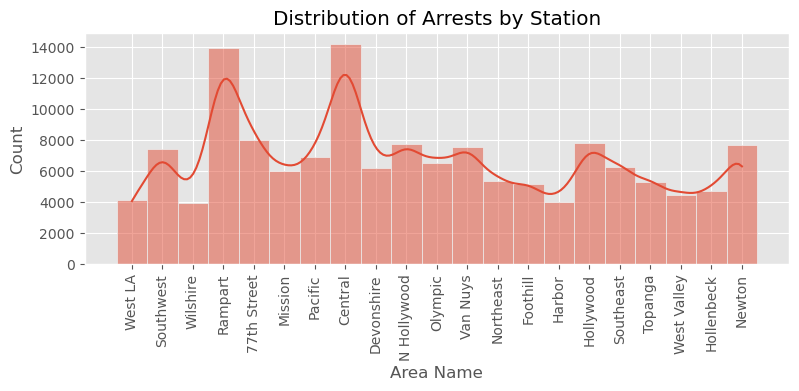

In [42]:
plt.style.use('ggplot')
plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
sns.histplot(df_a['Area Name'], kde = True)
plt.title('Distribution of Arrests by Station')
plt.xticks(rotation=90) 
plt.show()

## Crime Data

In [43]:
# Read the CSV file directly from S3
### FOR SASHA DF ###
# df_crime = wr.s3.read_csv("s3://sagemaker-us-east-1-643862913351/ads508-group7/Crime_Data_from_2020_to_Present.csv")

### FOR CYNTHIA DF ###
df_crime = wr.s3.read_csv("s3://ads508-group7/Crime_Data_from_2020_to_Present.csv")

# Display the first few rows
df_crime.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.00,998.00,NaN,NaN,1900 S LONGWOOD AV,NaN,34.04,-118.35
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.00,998.00,NaN,NaN,1000 S FLOWER ST,NaN,34.04,-118.26
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.00,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.02,-118.30
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.00,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.16,-118.44
4,200412582,09/09/2020 12:00:00 AM,09/09/2020 12:00:00 AM,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510.00,NaN,NaN,NaN,200 E AVENUE 28,NaN,34.08,-118.21


In [44]:
df_crime.shape

(1005104, 28)

In [45]:
#are there duplicates?
df_crime.duplicated().sum()

0

In [46]:
df_crime.dtypes

DR_NO               int64
Date Rptd          object
DATE OCC           object
TIME OCC            int64
AREA                int64
AREA NAME          object
Rpt Dist No         int64
Part 1-2            int64
Crm Cd              int64
Crm Cd Desc        object
Mocodes            object
Vict Age            int64
Vict Sex           object
Vict Descent       object
Premis Cd         float64
Premis Desc        object
Weapon Used Cd    float64
Weapon Desc        object
Status             object
Status Desc        object
Crm Cd 1          float64
Crm Cd 2          float64
Crm Cd 3          float64
Crm Cd 4          float64
LOCATION           object
Cross Street       object
LAT               float64
LON               float64
dtype: object

In [69]:
# Convert date time stamps from object to datetime
df_crime['DATE OCC'] = pd.to_datetime(df_crime['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')

# will drop Date Rptd, and just use DATE OCC for the rest of the project
df_cr = df_crime.drop('Date Rptd', axis=1)

# Check the new dataframe shape and top rows
print(df_cr.shape)
print(df_cr.head())


(1005104, 27)
       DR_NO   DATE OCC  TIME OCC  AREA   AREA NAME  Rpt Dist No  Part 1-2  \
0  190326475 2020-03-01      2130     7    Wilshire          784         1   
1  200106753 2020-02-08      1800     1     Central          182         1   
2  200320258 2020-11-04      1700     3   Southwest          356         1   
3  200907217 2020-03-10      2037     9    Van Nuys          964         1   
4  200412582 2020-09-09       630     4  Hollenbeck          413         1   

   Crm Cd                               Crm Cd Desc         Mocodes  ...  \
0     510                          VEHICLE - STOLEN             NaN  ...   
1     330                     BURGLARY FROM VEHICLE  1822 1402 0344  ...   
2     480                             BIKE - STOLEN       0344 1251  ...   
3     343  SHOPLIFTING-GRAND THEFT ($950.01 & OVER)       0325 1501  ...   
4     510                          VEHICLE - STOLEN             NaN  ...   

   Status   Status Desc Crm Cd 1  Crm Cd 2 Crm Cd 3  Crm Cd 

In [71]:
#drop everything before 1/1/2023
df_cr = df_cr[df_cr['DATE OCC'] >= pd.Timestamp('1/01/2023')]

df_cr.shape

(360130, 27)

In [72]:
df_cr.head()

,DR_NO,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
644974,230611294,2023-06-17,1140,6,Hollywood,668,1,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),1822 0325 2004,...,IC,Invest Cont,442.00,NaN,NaN,NaN,5500 W SUNSET BL,NaN,34.10,-118.31
644975,230106843,2023-02-11,1630,1,Central,191,1,440,THEFT PLAIN - PETTY ($950 & UNDER),0913 0344 0603,...,IC,Invest Cont,440.00,NaN,NaN,NaN,1400 WRIGHT ST,NaN,34.04,-118.27
644976,231515059,2023-09-19,1030,15,N Hollywood,1549,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",1309 0421 0913 0334,...,IC,Invest Cont,230.00,761.00,NaN,NaN,BURBANK BL,CAHUENGA BL,34.17,-118.36
644977,230110347,2023-04-10,816,1,Central,192,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,0344 1822,...,IC,Invest Cont,331.00,NaN,NaN,NaN,1300 S FLOWER ST,NaN,34.04,-118.27
644978,230618504,2023-12-01,110,6,Hollywood,639,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,1202 1814 0913 0319 2001 1813 2000 0400 0448,...,AO,Adult Other,626.00,NaN,NaN,NaN,5400 RUSSELL AV,NaN,34.10,-118.31


### Data Quality Reports

In [73]:
#dqr continous
pd.options.display.float_format = '{:.2f}'.format
cont_df_cr = dqr_cont(df_cr)
cont_df_cr

,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Standard Deviation
0,DR_NO,360130,0,360130,2315.00,230818079.25,234806576.42,231710592.50,240706967.75,252104112.00,4934761.37
1,TIME OCC,360130,0,1439,1.00,912.00,1351.26,1430.00,1900.00,2359.00,645.08
2,AREA,360130,0,21,1.00,5.00,10.61,11.00,16.00,21.00,6.15
3,Rpt Dist No,360130,0,1164,101.00,564.00,1107.84,1132.00,1605.00,2199.00,615.79
4,Part 1-2,360130,0,2,1.00,1.00,1.37,1.00,2.00,2.00,0.48
5,Crm Cd,360130,0,138,110.00,331.00,498.05,442.00,626.00,956.00,199.77
6,Vict Age,360130,0,100,-1.00,0.00,26.88,28.00,42.00,99.00,22.43
7,Premis Cd,360122,8,304,101.00,101.00,306.77,203.00,501.00,976.00,224.57
8,Weapon Used Cd,102521,257609,77,101.00,312.00,367.80,400.00,400.00,516.00,123.93
9,Crm Cd 1,360126,4,141,110.00,331.00,497.86,442.00,626.00,956.00,199.59


In [74]:
#dqr categorical
cat_df_cr = dqr_cat(df_cr)
cat_df_cr

,Feature,Count,Missing Values,Cardinality,Mode,Mode Frequency,Mode %,2nd Mode,2nd Mode Frequency,2nd Mode %
0,AREA NAME,360130,0,21,Central,27184,7.55,Pacific,21956,6.10
1,Crm Cd Desc,360130,0,138,VEHICLE - STOLEN,46027,12.78,BATTERY - SIMPLE ASSAULT,24251,6.73
2,Mocodes,296777,63353,108913,0344,15650,5.27,1822 0344,7078,2.38
3,Vict Sex,299317,60813,5,M,134996,45.10,F,119120,39.80
4,Vict Descent,299309,60821,20,H,98015,32.75,W,67592,22.58
5,Premis Desc,359851,279,297,STREET,99553,27.67,SINGLE FAMILY DWELLING,53324,14.82
6,Weapon Desc,102521,257609,77,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",53779,52.46,UNKNOWN WEAPON/OTHER WEAPON,13341,13.01
7,Status,360129,1,6,IC,299536,83.17,AO,31958,8.87
8,Status Desc,360130,0,6,Invest Cont,299536,83.17,Adult Other,31958,8.87
9,LOCATION,360130,0,49931,800 N ALAMEDA ST,1428,0.40,11800 SANTA MONICA BL,1202,0.33


## Foreclosure Data

In [55]:
# Read the CSV file directly from S3 2023 data

### SASHA DF ###
# df_fc2023 = wr.s3.read_csv("s3://sagemaker-us-east-1-643862913351/ads508-group7/2023_Registered_Foreclosure_Properties.csv")

### CYNTHIA DF ###
df_fc2023 = wr.s3.read_csv("s3://ads508-group7/2023_Registered_Foreclosure_Properties.csv")

# Display the first few rows
df_fc2023.head()

,APN,Registered Date,Property Type,Property Address,Property City,Property State,Property Zip,Council District,Lender,Lender Contact,Lender Contact Phone,Property Management,Property Management Contact,Property Management Address,Property Management Contact Phone,lon,lat,Property on map
0,2005012003,10/19/2023,Single Family,8361 N WOODLAKE AVE,LOS ANGELES,CA,91304,12,HML Investments,Cynthia Rivera,818-308-4443,ZVN Properties Inc,Arek Helcberger,957 E Cherry ST Canal Fulton OH 44614,330-854-5890,-118.63,34.22,POINT (-118.63231 34.22141)
1,2005018009,01/11/2023,Single Family,8349 N HILLARY DR,LOS ANGELES,CA,93063,12,Select Portfolio Servicing,Select Portfolio Servicing,888-349-8964,edward zubia,Edward Zubia,3540 willshire BLVD los angeles CA 90010,213-804-7437,-118.64,34.22,POINT (-118.64078 34.221)
2,2010005010,02/07/2023,Single Family,21811 W GRESHAM ST,LOS ANGELES,CA,93063,12,Fay Servicing,Eric Moore,877-338-3791,Safeguard,Code Compliance,7887 Safeguard Cir Valley View OH 44125,800-852-8306,-118.60,34.23,POINT (-118.60343 34.23144)
3,2010009038,09/12/2023,Single Family,21938 W LONDELIUS ST,LOS ANGELES,CA,91304,12,NEW AMERICAN FUNDING,KARLA HOWES,949-445-8824,SO CAL INSPECTORS INC,SUZANNE PHILLIPS,9525 Stewart and Gray RD Downey CA 90241,949-445-8824,-118.61,34.23,POINT (-118.60575 34.22912)
4,2010010027,10/18/2023,Single Family,22151 W PARTHENIA ST,LOS ANGELES,CA,93063,12,Specialized Loan Servicing LLC on behalf of be...,Douglas Randall,720-563-8186,Genstone Realty,Mark Giltner,15338 Central AVE Chino CA 91710,909-261-5415,-118.61,34.23,POINT (-118.60936 34.22832)


In [56]:
df_fc2023.shape

(2080, 18)

In [57]:
#are there duplicates?
df_fc2023.duplicated().sum()

0

In [58]:
df_fc2023.dtypes

APN                                    int64
Registered Date                       object
Property Type                         object
Property Address                      object
Property City                         object
Property State                        object
Property Zip                           int64
Council District                       int64
Lender                                object
Lender Contact                        object
Lender Contact Phone                  object
Property Management                   object
Property Management Contact           object
Property Management Address           object
Property Management Contact Phone     object
lon                                  float64
lat                                  float64
Property on map                       object
dtype: object

In [59]:
#dqr contin, 2023
pd.options.display.float_format = '{:.2f}'.format
cont_df_23 = dqr_cont(df_fc2023)
cont_df_23

,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Standard Deviation
0,APN,2080,0,1910,2005012003.00,2527010020.00,4088322295.99,4313008024.50,5432033272.75,7559039036.00,1585625055.47
1,Property Zip,2080,0,115,90001.00,90037.00,90661.57,90210.00,91342.00,99999.00,760.13
2,Council District,2080,0,15,1.00,4.00,8.03,8.00,12.00,15.00,4.00
3,lon,2080,0,1831,-118.66,-118.47,-118.39,-118.38,-118.29,-118.16,0.11
4,lat,2080,0,1819,33.71,34.00,34.10,34.10,34.21,34.33,0.13


In [60]:
#dqr categorical 2023
cat_df_23 = dqr_cat(df_fc2023)
cat_df_23

,Feature,Count,Missing Values,Cardinality,Mode,Mode Frequency,Mode %,2nd Mode,2nd Mode Frequency,2nd Mode %
0,Registered Date,2080,0,249,01/03/2023,161,7.74,01/11/2023,78,3.75
1,Property Type,2080,0,4,Single Family,1681,80.82,Multi-Family,371,17.84
2,Property Address,2080,0,1885,1735 FULLER AVE,4,0.19,1735 FULLER AVE,4,0.19
3,Property City,2080,0,29,LOS ANGELES,1916,92.12,VAN NUYS,42,2.02
4,Property State,2080,0,1,CA,2080,100.00,None,0,0.00
5,Lender,2078,2,351,Specialized Loan Servicing LLC C/O Computersha...,154,7.41,Select Portfolio Servicing,135,6.50
6,Lender Contact,2080,0,285,Eric Moore,464,22.31,Select Portfolio Servicing,181,8.70
7,Lender Contact Phone,2080,0,258,877-338-3791,473,22.74,888-349-8964,200,9.62
8,Property Management,1921,159,187,Edward Zubia,175,9.11,SFP,167,8.69
9,Property Management Contact,1922,158,174,Code Compliance,301,15.66,Dehavillyn Mack,170,8.84


In [62]:
# Read the CSV file directly from S3, 2024 data
### SASHA DF ###
#df_fc2024 = wr.s3.read_csv("s3://sagemaker-us-east-1-643862913351/ads508-group7/2024_Registered_Foreclosure_Properties.csv")

### CYNTHIA DF ###
df_fc2024 = wr.s3.read_csv("s3://ads508-group7/2024_Registered_Foreclosure_Properties.csv")

# Display the first few rows
df_fc2024.head()

,APN,Registered Date,Property Type,PropertyAddress,PropertyCity,PropertyState,PropertyZip,CouncilDistrict,Lender,LenderContact,LenderContactPhone,PropertyManagement,PropertyManagementContact,PropertyManagementAddress,PropertyMgmtContactPhone,lon,lat,Property map
0,2010010029,2024-07-31T00:00:00.000,Single Family,22171 W PARTHENIA ST,LOS ANGELES,CA,91304,12,BSI Financial Services,Registration Department,814-827-4661,Elliott J Services LLC,Elliott Ramirez,242 E Cottonwood ST 1 ONTARIO CA 91761,909-262-4175,-118.61,34.23,POINT (-118.60975 34.22866)
1,2010005010,2024-02-05T00:00:00.000,Single Family,21811 W GRESHAM ST,LOS ANGELES,CA,93063,12,Fay Servicing LLC,Eric Moore,877-338-3791,Safeguard,Code Compliance,27720 Jefferson AVE Temecula CA 92590,877-338-3791,-118.60,34.23,POINT (-118.60343 34.23144)
2,2023021019,2024-01-04T00:00:00.000,Single Family,22314 W COHASSET ST,LOS ANGELES,CA,91303,3,Shellpoint Mortgage Servicing,Eric Moore,877-338-3791,Guardian,Code Compliance,27720 CA AVE 230 Temecula CA 92590,877-338-3791,-118.61,34.21,POINT (-118.61295 34.2065)
3,2012003020,2024-09-27T00:00:00.000,Single Family,22146 W CANTARA ST,LOS ANGELES,CA,93063,3,Mr Cooper,Paula Acosta,888-456-0714,"New Beginning Properties, Inc.",Jose Chavez,445 W 34th ST San Bernardino CA 92405,877-339-8202,-118.61,34.22,POINT (-118.60987 34.21779)
4,2042006081,2024-11-15T00:00:00.000,Single Family,23029 W DEL VALLE ST,LOS ANGELES,CA,91364,3,Shellpoint Mortgage Servicing,Eric Moore,877-338-3791,ServiceLink,Code Compliance,27720 CA AVE 230 Temecula CA 92590,877-338-3791,-118.63,34.16,POINT (-118.62703 34.16393)


In [63]:
df_fc2024.shape

(2009, 18)

In [64]:
#are there duplicates?
df_fc2024.duplicated().sum()

0

In [65]:
df_fc2024.dtypes

APN                            int64
Registered Date               object
Property Type                 object
PropertyAddress               object
PropertyCity                  object
PropertyState                 object
PropertyZip                    int64
CouncilDistrict                int64
Lender                        object
LenderContact                 object
LenderContactPhone            object
PropertyManagement            object
PropertyManagementContact     object
PropertyManagementAddress     object
PropertyMgmtContactPhone      object
lon                          float64
lat                          float64
Property map                  object
dtype: object

In [66]:
#dqr contin, 2024
pd.options.display.float_format = '{:.2f}'.format
cont_df_24 = dqr_cont(df_fc2024)
cont_df_24

,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Standard Deviation
0,APN,2009,0,1869,2005016015.00,2532010072.00,4108194019.91,4325006093.00,5419028030.00,7560013046.00,1567469259.38
1,PropertyZip,2009,0,115,90001.00,90037.00,90642.63,90077.00,91342.00,99999.00,739.80
2,CouncilDistrict,2009,0,15,1.00,4.00,8.11,8.00,12.00,15.00,3.97
3,lon,2009,0,1794,-118.66,-118.47,-118.39,-118.37,-118.30,-118.16,0.11
4,lat,2009,0,1793,33.71,34.00,34.10,34.09,34.20,34.33,0.13


In [67]:
#dqr categorical 2024
cat_df_24 = dqr_cat(df_fc2024)
cat_df_24

,Feature,Count,Missing Values,Cardinality,Mode,Mode Frequency,Mode %,2nd Mode,2nd Mode Frequency,2nd Mode %
0,Registered Date,2009,0,286,2024-01-04T00:00:00.000,117,5.82,2024-01-08T00:00:00.000,59,2.94
1,Property Type,2009,0,4,Single Family,1609,80.09,Multi-Family,337,16.77
2,PropertyAddress,2009,0,1847,5460 N WHITE OAK AVE,5,0.25,10701 WILSHIRE,4,0.20
3,PropertyCity,2008,1,28,LOS ANGELES,1846,91.93,HOLLYWOOD,44,2.19
4,PropertyState,2009,0,1,CA,2009,100.00,None,0,0.00
5,Lender,2009,0,343,Shellpoint Mortgage Servicing,248,12.34,Select Portfolio Servicing,169,8.41
6,LenderContact,2009,0,296,Eric Moore,669,33.30,Select Portfolio Servicing,190,9.46
7,LenderContactPhone,2009,0,282,877-338-3791,673,33.50,888-349-8964,206,10.25
8,PropertyManagement,1877,132,227,Edward Zubia,160,8.52,Guardian Asset Management,137,7.30
9,PropertyManagementContact,1879,130,188,Code Compliance,693,36.88,Edward Zubia,127,6.76


# Transformations

## Transformations on Crime DF

In [83]:
# We want to roll date occurred to quarterly view
#then create a new column, Quarter
df_cr['Quarter'] = 'Q' + df_cr['DATE OCC'].dt.quarter.astype(str)

In [84]:
df_cr.head()

,DR_NO,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,Quarter
644974,230611294,2023-06-17,1140,6,Hollywood,668,1,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),1822 0325 2004,...,Invest Cont,442.00,NaN,NaN,NaN,5500 W SUNSET BL,NaN,34.10,-118.31,Q2
644975,230106843,2023-02-11,1630,1,Central,191,1,440,THEFT PLAIN - PETTY ($950 & UNDER),0913 0344 0603,...,Invest Cont,440.00,NaN,NaN,NaN,1400 WRIGHT ST,NaN,34.04,-118.27,Q1
644976,231515059,2023-09-19,1030,15,N Hollywood,1549,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",1309 0421 0913 0334,...,Invest Cont,230.00,761.00,NaN,NaN,BURBANK BL,CAHUENGA BL,34.17,-118.36,Q3
644977,230110347,2023-04-10,816,1,Central,192,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,0344 1822,...,Invest Cont,331.00,NaN,NaN,NaN,1300 S FLOWER ST,NaN,34.04,-118.27,Q2
644978,230618504,2023-12-01,110,6,Hollywood,639,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,1202 1814 0913 0319 2001 1813 2000 0400 0448,...,Adult Other,626.00,NaN,NaN,NaN,5400 RUSSELL AV,NaN,34.10,-118.31,Q4


In [85]:
#View the incidents by quarter

quarterly_incidents = df_cr.groupby('Quarter').size().reset_index(name='Incident Count')

# Display the result
print(quarterly_incidents)

  Quarter  Incident Count
0      Q1          110509
1      Q2           87049
2      Q3           84139
3      Q4           78433


In [90]:
# we are seeing an increase in Q1 because it includes Q1 2025, whereas the rest of the quarters do not have data on 2025... DO WE CONSIDER DROPPING 2025 data?

In [88]:
# drop any other variables we've deemed irrelevant for our project
df_cr_mod = df_cr.drop(
    ['TIME OCC', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 
                 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street'], axis=1)

In [89]:
# Group by AREA and the quarter, then count the incidents
quarterly_incidents_byAREA = df_cr_mod.groupby(['AREA', 'Quarter']).size().reset_index(name='Crime Count')

# Display the result
print(quarterly_incidents_byAREA)

    AREA Quarter  Crime Count
0      1      Q1         7830
1      1      Q2         6136
2      1      Q3         6858
3      1      Q4         6360
4      2      Q1         5024
..   ...     ...          ...
79    20      Q4         3788
80    21      Q1         4594
81    21      Q2         3873
82    21      Q3         3405
83    21      Q4         3318

[84 rows x 3 columns]


## Transformations on Arrest DF

In [92]:
# We want to roll date occurred to quarterly view
#then create a new column, Quarter
df_a['Quarter'] = 'Q' + df_a['Arrest Date'].dt.quarter.astype(str)

/tmp/ipykernel_132/2372497988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a['Quarter'] = 'Q' + df_a['Arrest Date'].dt.quarter.astype(str)


In [95]:
# Create a copy of df_a to avoid setting with a slice
df_ar = df_a.copy()

In [97]:
# Create the 'Quarter' column based on 'Arrest Date'
df_ar['Quarter'] = 'Q' + df_ar['Arrest Date'].dt.quarter.astype(str)

In [100]:
#View the arrests by quarter

quarterly_arrests = df_ar.groupby('Quarter').size().reset_index(name='Arrest Count')

# Display the result
print(quarterly_arrests)

  Quarter  Arrest Count
0      Q1         37863
1      Q2         35401
2      Q3         36514
3      Q4         33101


In [101]:
# drop any other variables we've deemed irrelevant for our project
df_ar_mod = df_ar.drop(
    ['Report Type', 'Time', 'Area Name', 'Reporting District', 'Age', 'Sex Code', 'Descent Code', 'Charge Group Code', 'Charge Group Description', 
     'Arrest Type Code', 'Charge', 'Charge Description', 'Disposition Description', 'Address', 'Cross Street', 'Location', 'Booking Date', 'Booking Time',
     'Booking Location', 'Booking Location Code'], axis=1)

In [103]:
# Group by Area ID and the quarter, then count the incidents
quarterly_arrests_byAreaID = df_ar_mod.groupby(['Area ID', 'Quarter']).size().reset_index(name='Arrest Count')

# Display the result
print(quarterly_arrests_byAreaID)

    Area ID Quarter  Arrest Count
0         1      Q1          3596
1         1      Q2          2823
2         1      Q3          3852
3         1      Q4          3911
4         2      Q1          2829
..      ...     ...           ...
79       20      Q4          1448
80       21      Q1          1343
81       21      Q2          1363
82       21      Q3          1312
83       21      Q4          1264

[84 rows x 3 columns]


## Transformations on Foreclosure DFs